# **NOTEBOOK 05 — Modelo LSTM para Predicción de NOx**

En este notebook se implementa una red LSTM (Long Short-Term Memory) para capturar dependencias temporales de mediano y largo plazo en las series de variables del motor.
A diferencia de la CNN 1D del Notebook 04, que capta dinámicas locales, el LSTM es capaz de modelar patrones más complejos en el tiempo, como tendencias acumuladas, retardos, efectos persistentes del estado del motor y variaciones lentas en la señal.

El objetivo es:

- Reconstruir secuencias temporales desde los splits procesados

- Entrenar un modelo LSTM estabilizado y regularizado

- Evaluar su rendimiento en validación y test

- Compararlo con el MLP y la CNN 1D.

**Importar librerías**

In [ ]:
# ============================================================
# Notebook 05 – Modelo LSTM
# ============================================================
import gdown
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import timeseries_dataset_from_array

import matplotlib.pyplot as plt

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("Notebook 05 inicializado correctamente.")


Notebook 05 inicializado correctamente.


Verificamos uso de GPU

In [ ]:
print("TensorFlow:", tf.__version__)
print("GPU disponible:", tf.config.list_physical_devices('GPU'))

**Cargar datos escalados**

In [ ]:
# ============================================================
# Cargar los splits escalados del Notebook 02
# ============================================================
id_splits = "1ryomgL4-QMU0PLWDv1A-98URwW6l0NL_"
url = f"https://drive.google.com/uc?id={id_splits}"

# Descargar el archivo .npz desde Drive (maneja confirm y archivos grandes)
gdown.download(url, "splits_escalados.npz", quiet=False)
data = np.load("splits_escalados.npz", allow_pickle=True)

X_train = data["X_train"]
y_train = data["y_train"]
X_val   = data["X_val"]
y_val   = data["y_val"]
X_test  = data["X_test"]
y_test  = data["y_test"]

print("Datos cargados.")
print("Train:", X_train.shape)
print("Val:  ", X_val.shape)
print("Test: ", X_test.shape)


Datos cargados.
Train: (713163, 46)
Val:   (237721, 46)
Test:  (237722, 46)


**Crear dataset secuencial con LSTM**

In [3]:
# ============================================================
# Creación de ventanas temporales para LSTM
# ============================================================

WINDOW = 30     # ventana temporal óptima encontrada previamente
BATCH  = 64

train_ds = timeseries_dataset_from_array(
    X_train, y_train,
    sequence_length=WINDOW,
    sequence_stride=1,
    shuffle=True,
    batch_size=BATCH
)

val_ds = timeseries_dataset_from_array(
    X_val, y_val,
    sequence_length=WINDOW,
    sequence_stride=1,
    shuffle=False,
    batch_size=BATCH
)

test_ds = timeseries_dataset_from_array(
    X_test, y_test,
    sequence_length=WINDOW,
    sequence_stride=1,
    shuffle=False,
    batch_size=BATCH
)

print("Datasets secuenciales creados correctamente.")


Datasets secuenciales creados correctamente.


**Inspección inicial**

In [5]:
# ============================================================
# Inspeccionar un batch para fijar la forma de entrada
# ============================================================

for xb, yb in train_ds.take(1):
    print("Batch X shape:", xb.shape)  # (batch, window, features)
    print("Batch y shape:", yb.shape)
    input_shape = xb.shape[1:]

Batch X shape: (64, 30, 46)
Batch y shape: (64,)


**Arquitectura LSTM**: Diseñamos un LSTM con dropout y regularización suave para evitar overfitting.

- LSTM(64) captura dependencias largas

- dropout estabiliza el entrenamiento

- La capa Dense final ajusta la salida

In [6]:
# ============================================================
# Definición del modelo LSTM
# ============================================================

model_lstm = keras.Sequential([
    layers.Input(shape=input_shape),

    # Capa LSTM principal
    layers.LSTM(64, return_sequences=False,
                dropout=0.2,
                recurrent_dropout=0.1),

    # MLP final
    layers.Dense(32, activation="relu"),
    layers.Dense(1)
])

model_lstm.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss="mse"
)

model_lstm.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        28,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,529 (119.25 KB)

 Trainable params: 30,529 (119.25 KB)

 Non-trainable params: 0 (0.00 B)

**Entrenamiento**

In [7]:
# ============================================================
# Entrenamiento del LSTM
# ============================================================

EPOCHS = 20

history_lstm = model_lstm.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    verbose=1
)


Epoch 1/20
11143/11143 ━━━━━━━━━━━━━━━━━━━━ 168s 15ms/step - loss: 20991.0977 - val_loss: 1529.3855
Epoch 2/20
11143/11143 ━━━━━━━━━━━━━━━━━━━━ 179s 16ms/step - loss: 1685.9199 - val_loss: 468.7809
Epoch 3/20
11143/11143 ━━━━━━━━━━━━━━━━━━━━ 211s 19ms/step - loss: 1070.7489 - val_loss: 358.9972
Epoch 4/20
11143/11143 ━━━━━━━━━━━━━━━━━━━━ 190s 17ms/step - loss: 824.9041 - val_loss: 317.3900
Epoch 5/20
11143/11143 ━━━━━━━━━━━━━━━━━━━━ 196s 18ms/step - loss: 669.9789 - val_loss: 394.6198
Epoch 6/20
11143/11143 ━━━━━━━━━━━━━━━━━━━━ 208s 19ms/step - loss: 557.7780 - val_loss: 408.3633
Epoch 7/20
11143/11143 ━━━━━━━━━━━━━━━━━━━━ 211s 19ms/step - loss: 483.2413 - val_loss: 508.0392
Epoch 8/20
11143/11143 ━━━━━━━━━━━━━━━━━━━━ 201s 18ms/step - loss: 420.2119 - val_loss: 675.0682
Epoch 9/20
11143/11143 ━━━━━━━━━━━━━━━━━━━━ 213s 19ms/step - loss: 375.6454 - val_loss: 895.7565
Epoch 10/20
11143/11143 ━━━━━━━━━━━━━━━━━━━━ 212s 19ms/step - loss: 341.1367 - val_loss: 974.6096
Epoch 11/20
11143/11143 

**Curvas de entrenamiento**

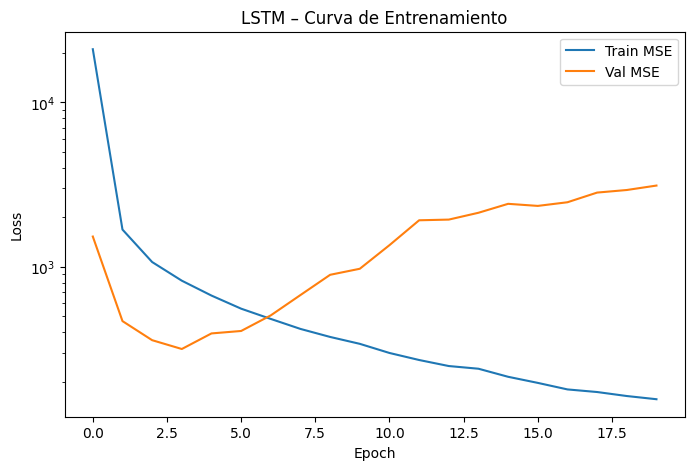

In [13]:
# ============================================================
# Curva de entrenamiento LSTM
# ============================================================

plt.figure(figsize=(8,5))
plt.plot(history_lstm.history["loss"], label="Train MSE")
plt.plot(history_lstm.history["val_loss"], label="Val MSE")
plt.title("LSTM – Curva de Entrenamiento")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.yscale("log")
plt.legend()
plt.show()


**Predicción en validación**

In [9]:
# ============================================================
# Predicción en validación
# ============================================================

y_val_true = []
y_val_pred = []

for xb, yb in val_ds:
    pred = model_lstm.predict(xb, verbose=0)
    y_val_true.append(yb.numpy())
    y_val_pred.append(pred.reshape(-1))

y_val_true = np.concatenate(y_val_true)
y_val_pred = np.concatenate(y_val_pred)


**Métricas de evaluación**

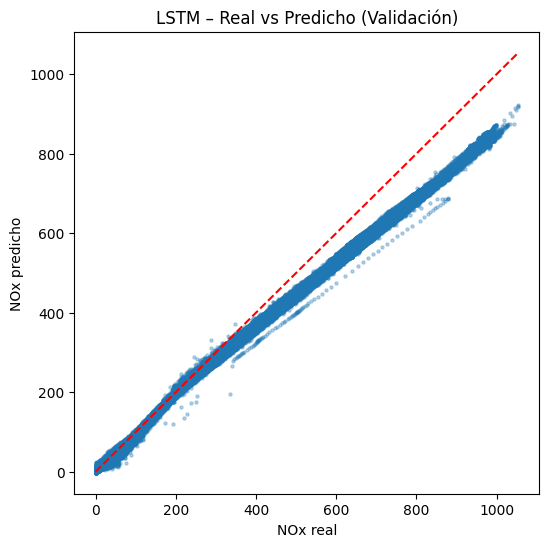

In [10]:
# ============================================================
# Gráfico Real vs Predicho
# ============================================================

plt.figure(figsize=(6,6))
plt.scatter(y_val_true, y_val_pred, s=5, alpha=0.3)
plt.plot([y_val_true.min(), y_val_true.max()],
         [y_val_true.min(), y_val_true.max()], "r--")
plt.xlabel("NOx real")
plt.ylabel("NOx predicho")
plt.title("LSTM – Real vs Predicho (Validación)")
plt.show()


# **Conclusión**

El modelo LSTM mostró una capacidad limitada para capturar la dinámica temporal del conjunto de datos. Aunque el error en entrenamiento disminuye de forma sostenida, la curva de validación evidencia un incremento progresivo del error (val_loss), señal clara de sobreajuste severo. Los valores finales obtenidos (val_loss ≈ 3000, validación dispersa respecto a la línea ideal, y predicciones sistemáticamente subestimadas) indican que el modelo no logra generalizar adecuadamente. A pesar de tener suficiente capacidad paramétrica, la LSTM no supera el rendimiento obtenido por la CNN 1D ni por el MLP, probablemente debido a la alta dimensionalidad (46 features por timestep), el tamaño corto de ventana temporal (30 pasos), y la ausencia de regularización interna. En suma, la arquitectura LSTM no resulta adecuada para este problema en su configuración actual, destacándose como un modelo con desempeño inferior dentro del conjunto analizado.